# MobileNet through Transfer Learning

In [1]:
import keras
from keras.applications.mobilenet import MobileNet
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.utils import np_utils
from keras import optimizers
from keras import losses
from matplotlib import pyplot as plt
from keras.datasets import cifar10
import numpy as np
from keras.callbacks import LearningRateScheduler
from scipy.misc import toimage


Using TensorFlow backend.


Shape of training data:  (50000, 32, 32, 3) (50000, 1)
Shape of testing data:  (10000, 32, 32, 3) (10000, 1)


c:\users\abhay\appdata\local\programs\python\python36\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
c:\users\abhay\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


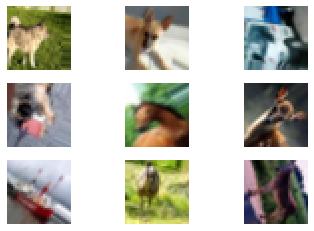

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('Shape of training data: ',x_train.shape,y_train.shape)
print('Shape of testing data: ',x_test.shape,y_test.shape)

datagen = ImageDataGenerator( rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.axis('off')
        plt.xlabel(y_batch[i])
        plt.imshow(toimage(X_batch[i].reshape(32, 32, 3)))
    # show the plot
    plt.show()
    break

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# z-score
mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

num_classes = 10
print(y_train[0])
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
print(y_train[0])

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [4]:
model = MobileNet(input_shape= (32,32,3),weights='imagenet',include_top=False)
# model.load_weights('mobilenet_1_0_224_tf.h5')

Instructions for updating:
Colocations handled automatically by placer.


c:\users\abhay\appdata\local\programs\python\python36\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [5]:
for layer in model.layers[:5]:
    layer.trainable = False

# last_layer = model.get_layer("conv_pw_13_relu")
# last_output = last_layer.output
# main_model = keras.models.Model(model.input)
# model.summary()

In [10]:
x = model.output
x = layers.Flatten()(x)
x = layers.Dense(512,activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10,activation="softmax")(x)

network = keras.models.Model(model.input,x)
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
__________

In [11]:
network.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [13]:
import timeit

start = timeit.default_timer()

network.fit(x_train, y_train,epochs=20,batch_size=64,verbose=1,validation_split=0.2,callbacks=[LearningRateScheduler(lr_schedule)])

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 83s 2ms/step - loss: 1.1544 - acc: 0.6192 - val_loss: 1.0114 - val_acc: 0.6665
Epoch 2/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.7541 - acc: 0.7500 - val_loss: 0.9779 - val_acc: 0.6935
Epoch 3/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.6364 - acc: 0.7903 - val_loss: 0.7629 - val_acc: 0.7428
Epoch 4/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.5711 - acc: 0.8131 - val_loss: 0.7865 - val_acc: 0.7387
Epoch 5/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.5127 - acc: 0.8317 - val_loss: 0.7994 - val_acc: 0.7454
Epoch 6/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.4613 - acc: 0.8502 - val_loss: 0.8101 - val_acc: 0.7401
Epoch 7/20
40000/40000 [==============================] - 77s 2ms/step - loss: 0.4135 - acc: 0.8623 - val_loss: 0.7913 - val_acc

In [14]:
stop = timeit.default_timer()
final_time = stop - start;
print("Time: ", final_time/3600);

Time:  0.42828015997222224


In [15]:
network.save('mobilenet_model_dropout.h5py')